## Overview

This notebook explores a practical and modern approach to low-resource *Named Entity Recognition (NER)* for the **Assamese** language by leveraging cross-lingual transfer learning and Parameter-Efficient Fine-Tuning (PEFT) techniques

The core idea is:

Use *Hindi* + *Bengali*  NER datasets to improve the representation quality of Assamese tokens, and then fine-tune the model on Assamese using lightweight **LoRA** adapters

## Motivation

Assamese is a low-resource Indic language with extremely limited annotated NER datasets.
Training deep transformer models (e.g., XLM-R) directly on such small datasets leads to:

- unstable training

- low accuracy

- poor generalization

However, linguistically and script-wise, Assamese is closely related to Bengali and partially similar to Hindi.
We leverage this relationship through:

- Cross-lingual pre-adaptation using Hindi + Bengali NER

- LoRA-based fine-tuning to avoid full-parameter updates

## Parameter-Efficient Fine-Tuning (PEFT)

Modern transformer models contain hundreds of millions of parameters.
Fine-tuning all of them for each new task is:

- slow

- expensive

- overfits on small datasets

- impractical for low-resource languages

PEFT solves this by training only a very small subset of parameters, while keeping the base model frozen.

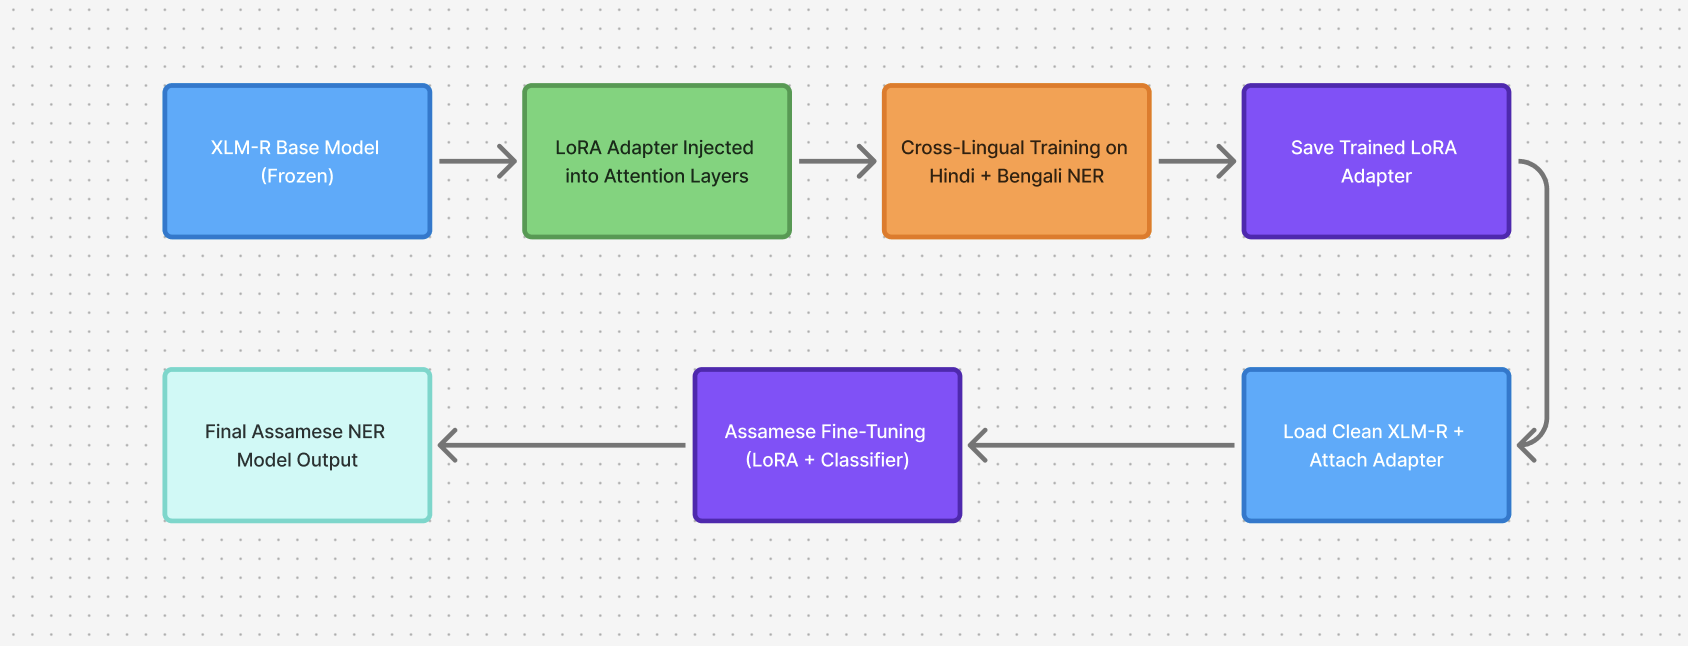

In [38]:
from IPython.display import Image, display
display(Image('/content/diagram.png'))


In [1]:
!pip install -q transformers datasets seqeval peft accelerate  evaluate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.2 MB/s eta 0:00:00


In [8]:
from seqeval.metrics import classification_report, f1_score
from datasets import load_dataset,DatasetDict, concatenate_datasets
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification,
)

In [3]:

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

### Baseline Model Overview

Before introducing *LoRA* adapters or cross-lingual alignment, we first establish a baseline using a straightforward fine-tuning of *XLM-RoBERTa Base* directly on the Assamese NER dataset.

This baseline helps us measure:

- how well XLM-R performs without any adaptation,

- how much benefit we gain later from Hindi + Bengali transfer learning,

- whether the Assamese dataset alone is sufficient to fine-tune a multilingual model

In [4]:
as_ds = load_dataset("wikiann", "as")

label_list = as_ds["train"].features["ner_tags"].feature.names



README.md: 0.00B [00:00, ?B/s]

as/validation-00000-of-00001.parquet:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

as/test-00000-of-00001.parquet:   0%|          | 0.00/9.68k [00:00<?, ?B/s]

as/train-00000-of-00001.parquet:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/100 [00:00<?, ? examples/s]

In [5]:


id2label = {i: l for i, l in enumerate(label_list)}
label2id = {l: i for i, l in enumerate(label_list)}

### Tokenization :
Tokenization is a fundamental step in NER pipelines because:

- Transformer models use subword-level representations

- NER labels are word-level

- Proper mapping ensures meaningful training signals

Correct tokenization alignment is a critical foundation before applying:

- LoRA

- cross-lingual training

- Assamese-specific fine-tuning

In [6]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        max_length=128
    )

    all_labels = []

    for i in range(len(examples["tokens"])):

        word_ids = tokenized_inputs.word_ids(batch_index=i)
        example_labels = examples["ner_tags"][i]
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(example_labels[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx

        all_labels.append(label_ids)

    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs


In [7]:
tokenized_ds = as_ds.map(tokenize_and_align_labels, batched=True)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

### Training of the baseline model

In [10]:
model = AutoModelForTokenClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=len(label_list)
)

data_collator = DataCollatorForTokenClassification(tokenizer)

training_args = TrainingArguments(
    output_dir="baseline-as-ner",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2849737604.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jeynang05 (jeynang05-nn) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,No log,1.843481
2,No log,1.701884
3,No log,1.631176


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=39, training_loss=1.7418156159229767, metrics={'train_runtime': 1512.1862, 'train_samples_per_second': 0.198, 'train_steps_per_second': 0.026, 'total_flos': 19598142643200.0, 'train_loss': 1.7418156159229767, 'epoch': 3.0})

In [13]:
preds_raw = preds.predictions.argmax(-1)
labels_raw = preds.label_ids

true_preds = [
    [id2label[p] for p, l in zip(pred, lab) if l != -100]
    for pred, lab in zip(preds_raw, labels_raw)
]
true_labels = [
    [id2label[l] for p, l in zip(pred, lab) if l != -100]
    for pred, lab in zip(preds_raw, labels_raw)
]

f1 = f1_score(true_labels, true_preds, average='micro')
print("Baseline XLM-R Assamese F1:", f1)

Baseline XLM-R Assamese F1: 0.13733905579399142


As we can see we got f1 score of 0.13 which is extremely low

# Training of the Proposed model

## How LoRA Works (Low-Rank Adaptation)

LoRA freezes the main transformer weights and inserts small trainable matrices into specific layers (usually attention layers like Query and Value).

Why LoRA helps:

Instead of updating a full transformer layer (millions of parameters), LoRA introduces two tiny matrices:

               A: down-projection (W → rank r)

               B: up-projection (rank r → W)

So instead of learning ΔW (huge), we learn:
ΔW = B × A (very small)

In [9]:
hi_ds = load_dataset("wikiann", "hi")
bn_ds = load_dataset("wikiann", "bn")

hi/validation-00000-of-00001.parquet:   0%|          | 0.00/64.7k [00:00<?, ?B/s]

hi/test-00000-of-00001.parquet:   0%|          | 0.00/65.0k [00:00<?, ?B/s]

hi/train-00000-of-00001.parquet:   0%|          | 0.00/312k [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/5000 [00:00<?, ? examples/s]

bn/validation-00000-of-00001.parquet:   0%|          | 0.00/56.0k [00:00<?, ?B/s]

bn/test-00000-of-00001.parquet:   0%|          | 0.00/57.6k [00:00<?, ?B/s]

bn/train-00000-of-00001.parquet:   0%|          | 0.00/554k [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

### Stage 1 — Cross-Lingual Alignment (Hindi + Bengali)

In this stage:

- The base XLM-R model remains frozen

- Only the LoRA adapter is trained

- The model learns how Hindi and Bengali tokens should be represented for NER

This step injects language-shared features into LoRA layers

### Stage 2 — Assamese Fine-Tuning

After the alignment step:

- We load a clean XLM-R base model

- Attach the trained LoRA adapter using PeftModel.from_pretrained

- Fine-tune on Assamese NER for 2–6 epochs

This stage adapts the aligned multilingual LoRA weights to Assamese-specific entity patterns

In [10]:
def align_labels(ds):
    return ds.map(tokenize_and_align_labels, batched=True)

hi_tok = align_labels(hi_ds)
bn_tok = align_labels(bn_ds)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [25]:
multilingual_train = DatasetDict({
    "train": concatenate_datasets([
        hi_tok["train"].shuffle(seed=42).select(range(5000)),
        bn_tok["train"].shuffle(seed=42).select(range(5000))
    ]),
    "validation": concatenate_datasets([
        hi_tok["validation"],
        bn_tok["validation"]
    ])
})

In [26]:

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["query", "value"],
    bias="lora_only",
    task_type="TOKEN_CLS"
)

peft_model = get_peft_model(model, lora_config)
peft_model.print_trainable_parameters()

trainable params: 318,727 || all params: 277,758,734 || trainable%: 0.1147


/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [27]:
xl_training_args = TrainingArguments(
    output_dir="cross-lingual-hi-bn",
    learning_rate=8e-5,
    per_device_train_batch_size=8,
    num_train_epochs=6,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    fp16=True,
)

xl_trainer = Trainer(
    model=peft_model,
    args=xl_training_args,
    train_dataset=multilingual_train["train"],
    eval_dataset=multilingual_train["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

xl_trainer.train()


/tmp/ipython-input-3320096437.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  xl_trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.571200,0.439305
2,0.467000,0.384081
3,0.390900,0.342306
4,0.386900,0.320200
5,0.349600,0.304806
6,0.354500,0.303788


TrainOutput(global_step=7500, training_loss=0.4657651870727539, metrics={'train_runtime': 521.5023, 'train_samples_per_second': 115.052, 'train_steps_per_second': 14.382, 'total_flos': 3933466122240000.0, 'train_loss': 0.4657651870727539, 'epoch': 6.0})

In [28]:
peft_model.save_pretrained("hi_bn_lora_adapter")


In [33]:
from transformers import AutoModelForTokenClassification
from peft import PeftModel

final_model = AutoModelForTokenClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=len(label_list)
)

final_model = PeftModel.from_pretrained(
    final_model,
    "hi_bn_lora_adapter"
)

final_model.set_adapter("default")


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# If we use bias="none" in LoRa config then run this code
'''final_model = AutoModelForTokenClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=len(label_list)
)

final_model = get_peft_model(final_model, lora_config)
final_model.load_adapter("hi_bn_lora_adapter" ,adapter_name="none")#adapter_name="hi_bn_xfer")
final_model.set_adapter("hi_bn_xfer")'''

In [34]:
final_args = TrainingArguments(
    output_dir="assamese-final-model",
    learning_rate=1e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    eval_strategy="epoch",
)

final_trainer = Trainer(
    model=final_model,
    args=final_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

final_trainer.train()


/tmp/ipython-input-4050113234.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,No log,0.661119
2,No log,0.568001
3,No log,0.570006


TrainOutput(global_step=39, training_loss=0.5809201949681991, metrics={'train_runtime': 3.1869, 'train_samples_per_second': 94.134, 'train_steps_per_second': 12.237, 'total_flos': 19667330611200.0, 'train_loss': 0.5809201949681991, 'epoch': 3.0})

In [35]:
preds = final_trainer.predict(tokenized_ds["test"])

preds_raw = preds.predictions.argmax(-1)
labels_raw = preds.label_ids

true_preds = [
    [id2label[p] for p, l in zip(pred, lab) if l != -100]
    for pred, lab in zip(preds_raw, labels_raw)
]
true_labels = [
    [id2label[l] for p, l in zip(pred, lab) if l != -100]
    for pred, lab in zip(preds_raw, labels_raw)
]

f1 = f1_score(true_labels, true_preds, average="micro")
print("Final Cross-Lingual Assamese F1:", f1)

Final Cross-Lingual Assamese F1: 0.7210300429184548


## Conclusion
- Baseline F1: ~0.13

- After LoRA + Cross-Lingual Training: ~0.72

XLM-R alone is not enough for Assamese NER due to low-resource constraints.
Cross-lingual signal + LoRA dramatically improves results